In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import PIL.Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from tqdm.notebook import tqdm
import timm
from sklearn.model_selection import train_test_split

import  metrics
import importlib
importlib.reload(metrics)

<module 'metrics' from '/home/david/Repos/FMI/Google-Landmark-Recognition-2021/metrics.py'>

In [26]:
all_landmarks_ids = pd.read_csv("eu_landmarks.csv", sep='\t')
print(f"All EU countries contain {len(all_landmarks_ids)} landmarks")

All EU countries contain 96245 landmarks


In [63]:
BASE_PATH = "/home/david/Downloads/landmark-recognition-2021"

train_df = pd.read_csv(BASE_PATH + "/train.csv")

In [64]:
len(train_df)

1580470

In [28]:
print(torch.version.cuda)
print("cuda available: " + str(torch.cuda.is_available()))

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
device

12.1
cuda available: True


device(type='cuda')

In [96]:
eu_train_df = train_df[train_df['landmark_id'].apply(lambda lid: lid in all_landmarks_ids['landmark_id'])]

In [97]:
len(eu_train_df)

745998

In [33]:
class CustomCountryDataset(Dataset):
    def __init__(self, photo_label_df, path, transform):
        self.photo_label_df = photo_label_df
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.photo_label_df)

    def __getitem__(self, index):
        row = self.photo_label_df.iloc[index]
        image_id = row['id']
        landmark_id_index = row['label_index']  # Use the label index
        file = image_id + '.jpg'
        subpath = '/'.join([char for char in image_id[0:3]])

        image = PIL.Image.open(self.path + '/' + subpath + '/' + file)
        X = self.transform(image)
        y = torch.tensor(landmark_id_index, dtype=torch.long)

        return X, y

In [34]:
transform_to_128 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [98]:
unique_classes = eu_train_df['landmark_id'].unique()
print(len(unique_classes))

# The cross entropy loss requires the index of the class instead of the label (for example [0-len(unique_classes)-1]
label_to_index = {label: idx for idx, label in enumerate(unique_classes)}

eu_train_with_index = pd.DataFrame(eu_train_df)
# Apply the mapping to the DataFrame
eu_train_with_index['label_index'] = eu_train_with_index['landmark_id'].map(label_to_index)

eu_train_with_index

38718


,id,landmark_id,label_index
0,17660ef415d37059,1,0
1,92b6290d571448f6,1,0
2,cd41bf948edc0340,1,0
3,fb09f1e98c6d2f70,1,0
4,25c9dfc7ea69838d,7,1
...,...,...,...
745993,cfafe4b282f606c6,96244,38717
745994,d926c61941895ab7,96244,38717
745995,db9f7b6f845051ca,96244,38717
745996,e6fcec0e56a6a305,96244,38717


In [37]:
index_to_label = {v: k for k, v in label_to_index.items()}

In [99]:
eu_train_df = eu_train_with_index

In [39]:
train_df, val_df = train_test_split(eu_train_df, test_size=0.1, random_state=42)
print(f"len(train_df)={len(train_df)}, len(val_df)={len(val_df)}")

len(train_df)=671398, len(val_df)=74600


In [40]:
unique_classes_train = train_df['label_index'].unique()
unique_classes_val = val_df['label_index'].unique()
len(unique_classes_train), len(unique_classes_val)

(38686, 24430)

In [41]:
train_dataset = CustomCountryDataset(
    photo_label_df=train_df,
    path=BASE_PATH + '/train',
    transform=transform_to_128,
)

val_dataset = CustomCountryDataset(
    photo_label_df=val_df,
    path=BASE_PATH + '/train',
    transform=transform_to_128,
)

In [42]:
batch_size = 64

In [43]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [19]:
def train(model,
          train_data_loader,
          validation_data_loader,
          optimizer,
          criterion,
          epochs,
          train_class_labels,
          checkpoint_path,
          device):
    
    model.to(device)

    results = {
        "train_loss": [],
        "train_gap": [],
        "val_loss": [],
        "val_gap": []
    }
    
    best_val_gap = 0.0
  
    for epoch in range(epochs):

        model.train()
        running_loss = 0.0
        
        train_predictions = []
        train_labels = []
        train_confidences = []
        
        for images, labels in tqdm(train_data_loader, desc='Training loop'):
            # Print labels to debug
            # print(f"Labels before moving to device: {labels}")
            # print(f"Labels dtype: {labels.dtype}, Labels min: {labels.min()}, Labels max: {labels.max()}")

            # Ensure labels are within the valid range
            # assert labels.min() >= 0 and labels.max() < 339, "Label out of range"

            # Print images shape and check for NaN or Inf values
            # print(f"Images shape: {images.shape}")
            assert not torch.isnan(images).any(), "Image tensor contains NaN"
            assert not torch.isinf(images).any(), "Image tensor contains Inf"

            # Ensure images are of type float
            images = images.float()
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
            #TODO maybe we should call model.eval() here?
            metrics.populate_confidence(train_confidences, train_labels, train_predictions, labels, outputs)
            
        train_loss = running_loss / len(train_data_loader.dataset)
        train_gap, _ = metrics.gap_metric(train_confidences, train_labels, train_predictions, train_class_labels)
        
        results["train_loss"].append(train_loss)
        results["train_gap"].append(train_gap)

        # Validation phase
        model.eval()
        running_loss = 0.0
        
        val_predictions = []
        val_labels = []
        val_confidences = []
        
        with torch.no_grad():
            for images, labels in tqdm(validation_data_loader, desc='Validation loop'):
                # Move inputs and labels to the device
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)
                
                metrics.populate_confidence(val_confidences, val_labels, val_predictions, labels, outputs)
        valid_loss = running_loss / len(validation_data_loader.dataset)
        valid_gap, _ = metrics.gap_metric(val_confidences, val_labels, val_predictions, train_class_labels)
        
        results["val_loss"].append(valid_loss)
        results["val_gap"].append(valid_gap)

        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_GAP: {train_gap:.4f} | "
            f"val_loss: {valid_loss:.4f} | "
            f"val_GAP: {valid_gap:.4f} "
        )
        
        # Checkpoint saving logic
        if valid_gap > best_val_gap:
            best_val_gap = valid_gap
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': valid_loss,
                        'gap': valid_gap},
                       checkpoint_path)

            print(f"Checkpoint saved at epoch {epoch+1} with validation GAP {valid_gap}")


    return results

In [44]:
class PretrainedClassifier(nn.Module):
    def __init__(self, pretrained_model, out_size, num_classes=53):
        super(PretrainedClassifier, self).__init__()
        self.base_model = timm.create_model(pretrained_model, pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        #making a classfier
        self.classifier = nn.Linear(out_size, num_classes)

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [45]:
efficient_net = PretrainedClassifier(num_classes=len(unique_classes), pretrained_model='efficientnet_b0', out_size=1280)


In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficient_net.parameters(), lr=0.001)

In [47]:
summary(efficient_net.to(device), (3, 128, 128))

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280]                --
├─EfficientNet: 1                                  []                        --
|    └─Conv2d: 2-1                                 [-1, 32, 64, 64]          864
├─Sequential: 1                                    []                        --
|    └─Conv2d: 2-2                                 [-1, 32, 64, 64]          (recursive)
├─EfficientNet: 1                                  []                        --
|    └─BatchNormAct2d: 2-3                         [-1, 32, 64, 64]          --
├─Sequential: 1                                    []                        --
|    └─BatchNormAct2d: 2-4                         [-1, 32, 64, 64]          (recursive)
├─EfficientNet: 1                                  []                        --
|    |    └─Identity: 3-1                          [-1, 32, 64, 64]          --
├─Sequential: 1 

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280]                --
├─EfficientNet: 1                                  []                        --
|    └─Conv2d: 2-1                                 [-1, 32, 64, 64]          864
├─Sequential: 1                                    []                        --
|    └─Conv2d: 2-2                                 [-1, 32, 64, 64]          (recursive)
├─EfficientNet: 1                                  []                        --
|    └─BatchNormAct2d: 2-3                         [-1, 32, 64, 64]          --
├─Sequential: 1                                    []                        --
|    └─BatchNormAct2d: 2-4                         [-1, 32, 64, 64]          (recursive)
├─EfficientNet: 1                                  []                        --
|    |    └─Identity: 3-1                          [-1, 32, 64, 64]          --
├─Sequential: 1 

In [48]:
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["val_loss"]

    accuracy = results["train_gap"]
    test_accuracy = results["val_gap"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_GAP")
    plt.plot(epochs, test_accuracy, label="val_GAP")
    plt.title("GAP")
    plt.xlabel("Epochs")
    plt.legend()

In [49]:
results = train(efficient_net, train_dataloader, val_dataloader, optimizer, criterion, epochs=10,
                train_class_labels=unique_classes_train, checkpoint_path='models/eu_efficient-net_128', device=device)

Training loop:   0%|          | 0/10491 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1166 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.5368 | train_GAP: 0.1958 | val_loss: 3.0262 | val_GAP: 0.4193 
Checkpoint saved at epoch 1 with validation GAP 0.41933540836029576


Training loop:   0%|          | 0/10491 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1166 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 1.7677 | train_GAP: 0.6083 | val_loss: 1.9947 | val_GAP: 0.5921 
Checkpoint saved at epoch 2 with validation GAP 0.5921202902004055


Training loop:   0%|          | 0/10491 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1166 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.7744 | train_GAP: 0.8042 | val_loss: 1.8448 | val_GAP: 0.6292 
Checkpoint saved at epoch 3 with validation GAP 0.6291956683801601


Training loop:   0%|          | 0/10491 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1166 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4263 | train_GAP: 0.8845 | val_loss: 1.8303 | val_GAP: 0.6501 
Checkpoint saved at epoch 4 with validation GAP 0.650050964503398


Training loop:   0%|          | 0/10491 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1166 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2740 | train_GAP: 0.9228 | val_loss: 1.8299 | val_GAP: 0.6615 
Checkpoint saved at epoch 5 with validation GAP 0.6615481342334019


Training loop:   0%|          | 0/10491 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1166 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.1928 | train_GAP: 0.9447 | val_loss: 1.8630 | val_GAP: 0.6659 
Checkpoint saved at epoch 6 with validation GAP 0.6659428963707188


Training loop:   0%|          | 0/10491 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1166 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.1465 | train_GAP: 0.9572 | val_loss: 1.9137 | val_GAP: 0.6678 
Checkpoint saved at epoch 7 with validation GAP 0.6677571165888733


Training loop:   0%|          | 0/10491 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1166 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.1178 | train_GAP: 0.9654 | val_loss: 1.9220 | val_GAP: 0.6721 
Checkpoint saved at epoch 8 with validation GAP 0.6721033638365835


Training loop:   0%|          | 0/10491 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1166 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.0968 | train_GAP: 0.9714 | val_loss: 1.9901 | val_GAP: 0.6684 


Training loop:   0%|          | 0/10491 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1166 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.0832 | train_GAP: 0.9754 | val_loss: 1.9750 | val_GAP: 0.6746 
Checkpoint saved at epoch 10 with validation GAP 0.6745787317131153


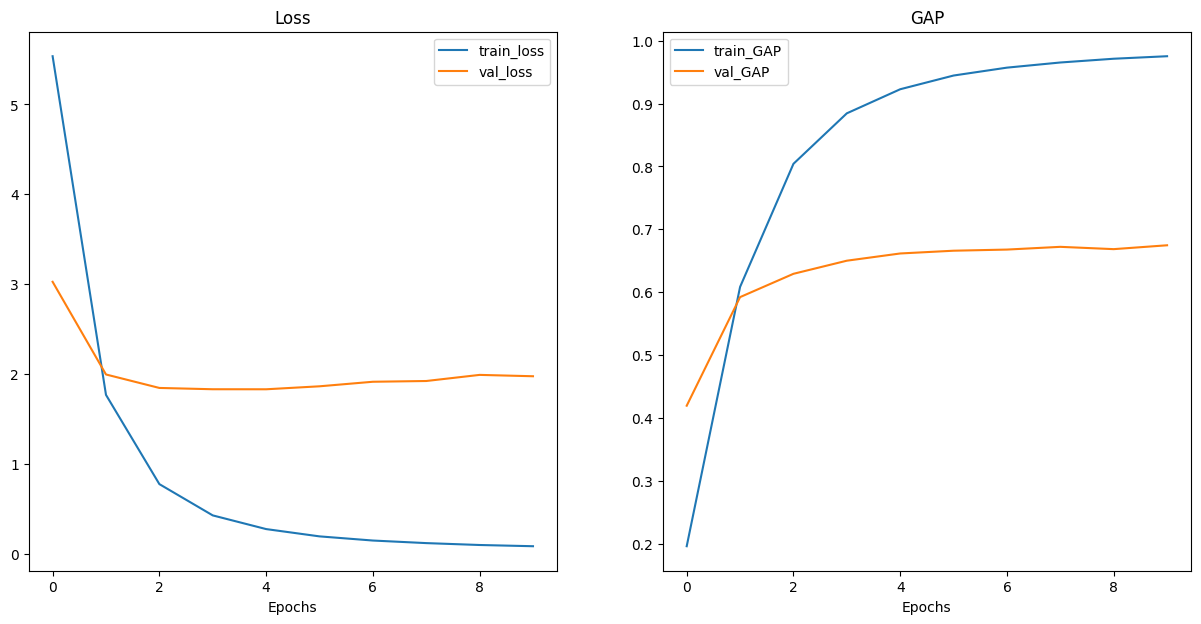

In [50]:
plot_loss_curves(results)

In [52]:
# Let's see how well the model on all EU dataset predicts on the bulgarian validation
bg_landmarks_ids = pd.read_csv("bg_landmarks.csv", sep='\t')
print(f"BG contains {len(bg_landmarks_ids)} landmarks")

BG contains 658 landmarks


In [116]:
bg_train_df = train_df[train_df['landmark_id'].isin(bg_landmarks_ids['landmark_id'])]
len(bg_train_df)

9418

In [85]:
bg_train_df

,id,landmark_id
3959,4db638f8d0dc1ce2,481
3960,4e454120ba3bfb36,481
3961,69ba8a4a5ecc9c61,481
3962,81dc5e647b5e9c8b,481
3963,a893e44faf1e9640,481
...,...,...
1580097,c58c445a89cc7ca9,203034
1580098,c9d6a8aa86d1fce5,203034
1580099,cc4cfcfce95fc633,203034
1580100,e48bf94f91142d96,203034


In [100]:
val_df

,id,landmark_id,label_index
690522,5a864297679dfab6,88553,35635
70853,27301e7ca03d09aa,9073,3649
17759,9fcbec55a86888b0,2260,892
64914,6513741e6ef25e11,8333,3355
376084,3cccf83e8649c6bc,47380,19172
...,...,...,...
414891,a01da4b748750ab5,52176,21128
37118,a09fbdab9f32adf3,4733,1898
540619,96e5da179151d99b,68974,27848
646557,089383eebd0d6e24,83139,33459


In [104]:
bg_val_df = val_df[val_df['landmark_id'].isin(bg_landmarks_ids['landmark_id'])]


In [109]:
bg_val_dataset = CustomCountryDataset(
    photo_label_df=bg_val_df,
    path=BASE_PATH + '/train',
    transform=transform_to_128,
)


bg_val_dataloader = DataLoader(
    dataset=bg_val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [111]:
bg_valid_gap, _ = metrics.calculate_gap(efficient_net, bg_val_dataloader,unique_classes_train, device)

Evaluating model:   0%|          | 0/9 [00:00<?, ?it/s]

In [113]:
f"Bulgarian val_GAP with model on all EU countries: {bg_valid_gap:.4f} "

'Bulgarian val_GAP with model on all EU countries: 0.7272 '

In [117]:
bg_landmarks_ids2 = pd.read_csv("bg_landmarks_ids.csv", sep='\t')
print(f"BG contains {len(bg_landmarks_ids2)} landmarks")

BG contains 658 landmarks


In [118]:
bg_landmarks_ids2.equals(bg_landmarks_ids)

True